In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import tensorflow as tf
#from tqdm import tqdm
import random as rn
from random import shuffle
from zipfile import ZipFile
from PIL import Image
from skimage.feature import hog
from skimage import feature, color, data
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow

In [ ]:
trn_img_path = "/content/drive/MyDrive/skin-cancer/train"
tst_img_path = "/content/drive/MyDrive/skin-cancer/test"

X_train =[] # Stores the training image features
label_train = [] # Stores the training image labels
X_test = [] # Stores the testing image features
label_test = [] # Stores the testing image label

In [ ]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
img_height = 180
img_width = 180

train_ds = image_dataset_from_directory(trn_img_path,
                                        seed = 123,
                                        image_size=(img_height, img_width),
                                        validation_split=0.2,
                                        subset='training')

Found 2637 files belonging to 2 classes.
Using 2110 files for training.


In [ ]:
class_names = train_ds.class_names
print(type(class_names), class_names)

<class 'list'> ['benign', 'malignant']


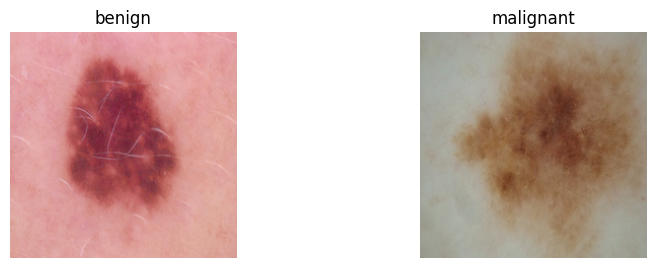

In [ ]:
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(trn_img_path), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[10]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

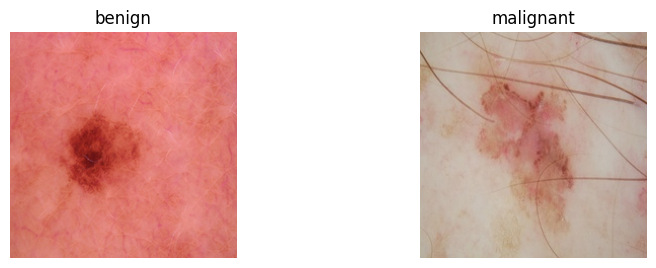

In [ ]:
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(tst_img_path), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[10]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

trn_img_path = '/content/drive/MyDrive/skin-cancer/train/'

# List of subdirectories to process
subdirectories = ['malignant', 'benign']

grayscale_images = []  # List to store grayscale images

# Loop through each subdirectory
for subdir in subdirectories:
    subdir_path = os.path.join(trn_img_path, subdir)

    # List all image files in the subdirectory
    image_files = os.listdir(subdir_path)

    # Calculate the number of images to process
    num_images_to_process = len(image_files) // 7

    # Process images in the subdirectory
    for i in range(num_images_to_process):
        image_file = image_files[i]
        img_path = os.path.join(subdir_path, image_file)

        # Print the image path for debugging
        print(f"Processing image: {img_path}")

        # Read, resize the image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading image: {img_path}")
            continue

        f_s = (200, 200)
        img = cv2.resize(img, f_s)

        # Display the resized image
        cv2_imshow(img)

        # Convert to grayscale
        img_gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grayscale_images.append(img_gr)  # Store the grayscale image in the list
        cv2_imshow(img_gr)

In [ ]:
enhanced_images = []

# Loop through each grayscale image
for img_gr in grayscale_images:
    # Enhance the grayscale image using histogram equalization
    enhanced_img = cv2.equalizeHist(img_gr)
    enhanced_images.append(enhanced_img)

    # Display the enhanced grayscale image
    plt.figure(figsize=(2, 2))
    plt.imshow(enhanced_img, cmap='gray')
    plt.title("Enhanced Grayscale Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
sharpened_images = []

# Define the sharpening kernel
sharpening_kernel = np.array([[0, -1, 0],
                              [-1, 5, -1],
                              [0, -1, 0]])

# Loop through each enhanced grayscale image
for enhanced_img in enhanced_images:
    # Apply the sharpening kernel to the image
    sharpened_img = cv2.filter2D(enhanced_img, -1, sharpening_kernel)
    sharpened_images.append(sharpened_img)

    # Display the sharpened image
    plt.figure(figsize=(2, 2))
    plt.imshow(sharpened_img, cmap='gray')
    plt.title("Sharpened Image")
    plt.axis("off")

    plt.show()

In [ ]:
gaussian_filtered_images = []

# Loop through each enhanced grayscale image
for sharpened_img in sharpened_images:
    # Gaussian filter to the enhanced grayscale image
    gaussian_filtered_img = cv2.GaussianBlur(sharpened_img, (5, 5), 0)
    gaussian_filtered_images.append(gaussian_filtered_img)

    # Gaussian filtered image display
    plt.figure(figsize=(2, 2))
    plt.imshow(gaussian_filtered_img, cmap='gray')
    plt.title("Gaussian Filtered Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
edge_detected_images = []

# Loop through each sharpened image
for gaussian_filtered_img in gaussian_filtered_images:
    # Canny edge detection to the image
    edges = cv2.Canny(gaussian_filtered_img, threshold1=30, threshold2=70)
    edge_detected_images.append(edges)

    # the edge-detected image display
    plt.figure(figsize=(2, 2))
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detected Image")
    plt.axis("off")

    plt.show()

In [ ]:
from skimage.feature import hog
from skimage import exposure
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# HOG parameters
hog_orientations = 8
hog_pixels_per_cell = (16, 16)
hog_cells_per_block = (1, 1)

def hog_data_extractor(edges):
    fd, _ = hog(edges, orientations=hog_orientations, pixels_per_cell=hog_pixels_per_cell,
                cells_per_block=hog_cells_per_block, visualize=True, multichannel=False)
    return fd

# Load your labels and HOG features here
X_train = []
X_test = []
label_train = []
label_test = []

# Path to your image root directory
img_root_path = '/content/drive/MyDrive/skin-cancer/train'

# Call jpeg_to_array function for each scene type and data type
def jpeg_to_array(scene_type, data_type):
    scene_path = os.path.join(img_root_path, scene_type.lower())
    print('Loading ' + data_type + ' images for scene type ' + scene_type)
    for img in os.listdir(scene_path):
        img_path = os.path.join(scene_path, img)
        if img_path.endswith('.jpg'):
            jpeg_data = cv2.imread(img_path)
            jpeg_data = cv2.resize(jpeg_data, (150, 150))
            hog_features = hog_data_extractor(edges)
            if data_type == 'Training':
                X_train.append(hog_features)
                label_train.append(str(scene_type))
            if data_type == 'Testing':
                X_test.append(hog_features)
                label_test.append(np.array(str(scene_type)))

# Call jpeg_to_array for each scene type and data type
scene_types = ['Benign', 'Malignant']
for scene_type in scene_types:
    jpeg_to_array(scene_type, 'Training')
    jpeg_to_array(scene_type, 'Testing')

# labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(label_train)
y_test_encoded = label_encoder.transform(label_test)

Loading Training images for scene type Benign


<ipython-input-15-33a95aa60198>:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, _ = hog(edges, orientations=hog_orientations, pixels_per_cell=hog_pixels_per_cell,


Loading Testing images for scene type Benign
Loading Training images for scene type Malignant
Loading Testing images for scene type Malignant


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC
lsvc = LinearSVC(random_state=0,tol=1e-5)
lsvc.fit(X_train,y_train_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05)

In [ ]:
y_svm = lsvc.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test_encoded,y_svm))

Accuracy on unknown data is 0.8001516875237011


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train,y_train_encoded)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
y_knn = neigh.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test_encoded,y_knn))

Accuracy on unknown data is 0.7322715206674251


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=20, random_state=40)
clf.fit(X_train,y_train_encoded)

RandomForestClassifier(max_depth=20, random_state=40)

In [ ]:
y_RF = clf.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test_encoded,y_RF))

Accuracy on unknown data is 0.9912779673871824


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print(classification_report(y_true = y_test_encoded, y_pred = y_RF, target_names= ['benign', 'malignant']))

              precision    recall  f1-score   support

      benign       1.00      0.99      0.99      1440
   malignant       0.99      0.99      0.99      1197

    accuracy                           0.99      2637
   macro avg       0.99      0.99      0.99      2637
weighted avg       0.99      0.99      0.99      2637



In [ ]:
def scene_predict(img_path):
    image = cv2.imread(img_path)
    ip_image = Image.open(img_path)
    image = cv2.resize(image, (150, 150))

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    prd_image_data = hog_data_extractor(gray_image)  # Extract HOG features from the grayscale image
    scene_predicted = clf.predict(prd_image_data.reshape(1, -1))[0]

    scene_labels = label_encoder.classes_
    predicted_label = scene_labels[scene_predicted]

    fig, ax = plt.subplots(1, 2, figsize=(6, 3),
                       subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow(ip_image)
    ax[0].set_title('Input image')

    ax[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Predicted scene: ' + predicted_label)

    plt.tight_layout()
    plt.show()

<ipython-input-15-33a95aa60198>:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, _ = hog(edges, orientations=hog_orientations, pixels_per_cell=hog_pixels_per_cell,


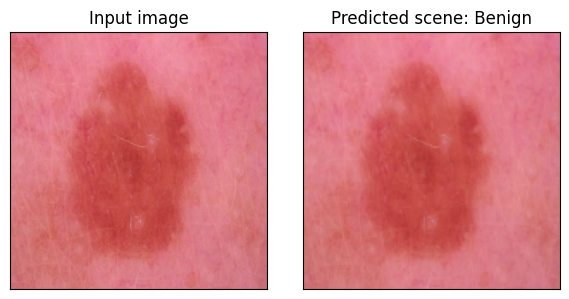

<ipython-input-15-33a95aa60198>:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, _ = hog(edges, orientations=hog_orientations, pixels_per_cell=hog_pixels_per_cell,


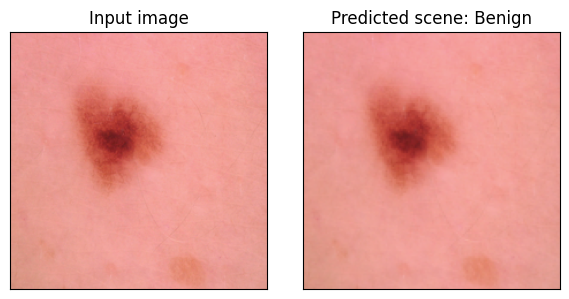

In [ ]:
ip_img_folder = "/content/drive/MyDrive/skin-cancer/test/benign"
ip_img_files = ['/content/drive/MyDrive/skin-cancer/test/benign/1042.jpg', '/content/drive/MyDrive/skin-cancer/test/benign/1146.jpg']
scene_predicted = [scene_predict(os.path.join(ip_img_folder,img_file))for img_file in ip_img_files]